# NB-AK6: Changes in Long-term snow and ice water equivanent for 21st early, mid and late period from historical period

## module loading...

In [1]:
%matplotlib inline  
import os
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from timeit import default_timer as timer

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)

mpl.rcParams['xtick.labelsize']='small'


The Python version: 3.7.0
xarray 0.16.2


In [2]:
from cmip5_oconus import print_date
print_date()

from cmip5_oconus.data_catalog import load_monthly_historical_hydro_datasets, resample_data
from cmip5_oconus.data_catalog import load_monthly_cmip5_hydro_datasets
from cmip5_oconus.plot import custom_div_cmap, MidpointNormalize, add_ylabel
from cmip5_oconus.utils import calc_change
from cmip5_oconus.data_catalog import DOMAIN

Last executed: 2022-04-16 15:33:50.677428 by mizukami on crhtc63


In [3]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(processes=9, threads=4, memory="108GB", queue='casper',
                  walltime='00:40:00')
cluster.scale(jobs=3)

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42553 instead
  http_address["port"], self.http_server.port


In [4]:
from dask.distributed import Client
client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.12.206.49:46441 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mizukami/proxy/{port}/status,Cluster Workers: 27 Cores: 108 Memory: 324.00 GB


-------------------------
## Setup 

In [3]:
figSave = True

In [4]:
gcms            = ["ACCESS1-3","CanESM2","CCSM4","CSIRO-Mk3-6-0","GFDL-ESM2M","HadGEM2-ES","inmcm4","MIROC5","MPI-ESM-MR","MRI-CGCM3"]
hydro_flux_vars = ['SWE', 'IWE']
period_hist     = slice('1970-01-01', '1999-12-31')
period_futr     = {'early' : slice('2010-01-01', '2039-12-31'),
                   'middle': slice('2040-01-01', '2069-12-31'),
                   'late'  : slice('2070-01-01', '2099-12-31')}

## Load the data

In [5]:
ds1 = xr.open_dataset(DOMAIN['AK'])
mask = ds1['mask'].where(ds1['mask']==1).notnull()

In [6]:
xr.set_options(file_cache_maxsize=12000)
histo_data = load_monthly_historical_hydro_datasets(models=gcms, variables=hydro_flux_vars, region='AK', parallel=False)
rcp45_data = load_monthly_cmip5_hydro_datasets(scen='rcp45', models=gcms, variables=hydro_flux_vars, region='AK', parallel=False)
rcp85_data = load_monthly_cmip5_hydro_datasets(scen='rcp85', models=gcms, variables=hydro_flux_vars, region='AK', parallel=False)

load_monthly_historical_hydro_datasets
load_monthly_cmip5_hydro_datasets
load_cmip5_dataset


100%|██████████| 10/10 [00:28<00:00,  2.83s/it]

load_obs_dataset


load_monthly_cmip5_hydro_datasets
load_cmip5_dataset


100%|██████████| 10/10 [00:52<00:00,  5.23s/it]

load_monthly_cmip5_hydro_datasets
load_cmip5_dataset



100%|██████████| 10/10 [00:51<00:00,  5.17s/it]


In [8]:
# Select only winter months - 1 through 6
histo_data_winter = {}
for key, val in histo_data.items():
    histo_data_winter[key] = histo_data[key].where(histo_data[key].time.dt.month.isin([1,2,3,4,5,6]), drop=True)
rcp45_data_winter = rcp45_data.where(rcp45_data.time.dt.month.isin([1,2,3,4,5,6]), drop=True)
rcp85_data_winter = rcp85_data.where(rcp85_data.time.dt.month.isin([1,2,3,4,5,6]), drop=True)

## Compute 30 year annual mean for 4 periods - historical, early, mid and late

In [9]:
histo_hydro_means = resample_data(histo_data['gcm'].sel(time=period_hist), region='AK', freq='AS', chunks=365).persist().mean('time')

rcp45_hydro_means = {}
rcp85_hydro_means = {}
for key, futr_period in period_futr.items():
    rcp45_hydro_means[key] = resample_data(rcp45_data.sel(time=futr_period), region='AK', freq='AS', chunks=365).persist().mean('time')
    rcp85_hydro_means[key] = resample_data(rcp85_data.sel(time=futr_period), region='AK', freq='AS', chunks=365).persist().mean('time')

In [10]:
# non-glacier pixels are zero, computing change in percent cause those pixes are filled with nan and plots get strange. so fill non zero (0.001) at non-glacier pixels.  
histo_hydro_means['IWE'] = histo_hydro_means['IWE'].where((histo_hydro_means['IWE']>0) | (np.isnan(histo_hydro_means['IWE'])), -0.001)

for key, futr_period in period_futr.items():
    rcp45_hydro_means[key]['IWE'] = rcp45_hydro_means[key]['IWE'].where((rcp45_hydro_means[key]['IWE']>0) | (np.isnan(rcp45_hydro_means[key]['IWE'])), -0.001)
    rcp85_hydro_means[key]['IWE'] = rcp85_hydro_means[key]['IWE'].where((rcp85_hydro_means[key]['IWE']>0) | (np.isnan(rcp85_hydro_means[key]['IWE'])), -0.001)

## Compute 30 year mean annual max SWE for 4 periods - historical, early, mid and late

In [11]:
hist_SWEmax_means  = histo_data['gcm']['SWE'].resample(time='AS').max('time', skipna=False).persist().mean('time')
hist_SWEmax_means = hist_SWEmax_means.rename('SWEmax')

rcp45_SWEmax_means = {}
rcp85_SWEmax_means = {}
for key, futr_period in period_futr.items():
    rcp45_SWEmax_means[key] = rcp45_data['SWE'].sel(time=futr_period).resample(time='AS').max('time', skipna=False).persist().mean('time')
    rcp85_SWEmax_means[key] = rcp85_data['SWE'].sel(time=futr_period).resample(time='AS').max('time', skipna=False).persist().mean('time')
    
    rcp45_SWEmax_means[key] = rcp45_SWEmax_means[key].rename('SWEmax')
    rcp85_SWEmax_means[key] = rcp85_SWEmax_means[key].rename('SWEmax')

## Combine SWEmax DataArray and SWE/IWE DataArray

In [12]:
histo_hydro_means['SWEmax'] = hist_SWEmax_means
for key, futr_period in period_futr.items():
        rcp45_hydro_means[key]['SWEmax'] = rcp45_SWEmax_means[key]
        rcp85_hydro_means[key]['SWEmax'] = rcp85_SWEmax_means[key]

## Compute difference in 30 year annual mean between historical and future

In [13]:
rcp45_hydro_30yr_diff = {}
rcp85_hydro_30yr_diff = {}
diff_rcp_hydro_30yr_change ={}
for key, futr_period in period_futr.items():
    rcp45_hydro_30yr_diff[key] = calc_change(histo_hydro_means, rcp45_hydro_means[key], pct=True).persist()
    rcp85_hydro_30yr_diff[key] = calc_change(histo_hydro_means, rcp85_hydro_means[key], pct=True).persist()
    
    diff_rcp_hydro_30yr_change[key] =rcp85_hydro_30yr_diff[key] - rcp45_hydro_30yr_diff[key]

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizuka

In [28]:
# mask pecent change is less than -99%  
for key, futr_period in period_futr.items():
    rcp45_hydro_30yr_diff[key] = rcp45_hydro_30yr_diff[key].where(rcp45_hydro_30yr_diff[key]>-99)
    rcp85_hydro_30yr_diff[key] = rcp85_hydro_30yr_diff[key].where(rcp85_hydro_30yr_diff[key]>-99)

In [138]:
upper[0,:]

array([1.        , 1.        , 0.85098039, 1.        ])

## Plotting

In [148]:
# create colormap for SWE and IWE
# ---------------
# option 0
# create a colormap that consists of
# - 1/5 : custom colormap, ranging from white to the first color of the colormap
# - 4/5 : existing colormap

# set upper part: 4 * 256/4 entries
upper = mpl.cm.YlGnBu(np.arange(256)) #upper = mpl.cm.Spectral(np.arange(256))

# set lower part: 1 * 256/4 entries
# - initialize all entries to 1 to make sure that the alpha channel (4th column) is 1
lower = np.ones((int(256/4),4))
# - modify the first three columns (RGB):
#   range linearly between white (1,1,1) and the first color of the upper colormap
for i in range(3):
    lower[:,i] = np.linspace(0.9, upper[0,i], lower.shape[0])

# combine parts of colormap
cmap0 = np.vstack(( lower, upper ))

# convert to matplotlib colormap
cmap0 = mpl.colors.ListedColormap(cmap, name='myColorMap', N=cmap0.shape[0])
cmap0.set_under('xkcd:light grey')

# option1
cmap1 = mpl.cm.GnBu
cmap1.set_under('xkcd:light grey')

# option 2
cmap2 = LinearSegmentedColormap.from_list('custom1', 
                                          [(0.00, 'xkcd:very light blue'),
                                           (0.25, 'xkcd:light blue'),
                                           (0.50, 'xkcd:lightish blue'),
                                           (0.75, 'xkcd:blue'),
                                           (1.00, 'xkcd:dark blue')], N=256)
cmap2.set_over('xkcd:dark purple')
cmap2.set_under('xkcd:light grey')

# create colormap for SWE and IWE change
# ---------------
# create a colormap that consists of
# 25 descrete colormap from red to blue

#cmap3 = custom_div_cmap(numcolors=15, mincol='xkcd:red', midcol='xkcd:light grey', maxcol='xkcd:blue')
cmap3 = LinearSegmentedColormap.from_list('custom1', 
                                          [(0.00, 'xkcd:tomato red'),
                                           (0.50, 'xkcd:light grey'),
                                           (1.00, 'xkcd:blue')], N=17)
cmap3.set_over('xkcd:dark purple')

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizuka

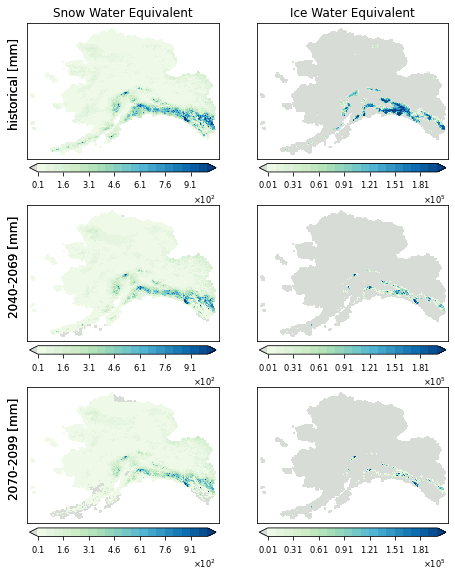

In [149]:
cm = {'mean': cmap1}

sfmt = mpl.ticker.ScalarFormatter(useMathText=True)
sfmt.set_powerlimits((0, 0))

style_kwargs = {'add_labels': False, 'xticks':[], 'yticks':[], 
                'cbar_kwargs': {'orientation':"horizontal", 'shrink':0.975, 'pad':0.03, 'format':sfmt}}
kwargs = {'SWE': {'levels':21, 'vmin':10,   'vmax':1010,   'cmap':cm['mean'], 'extend':'both', **style_kwargs},
          'IWE': {'levels':21, 'vmin':1000, 'vmax':201000, 'cmap':cm['mean'], 'extend':'both', **style_kwargs}
          }

var_title = {'SWE':'Snow Water Equivalent', 'IWE':'Ice Water Equivalent'}

fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(6.5,7.75))
plt.subplots_adjust(left=0.075, bottom=0.020, right=0.975, top=0.970, hspace=0.100)

for col, var in enumerate(['SWE','IWE']):
    histo_hydro_means.mean(dim='gcm')[var].plot.pcolormesh(ax=axes[0, col], **kwargs[var])
    rcp85_hydro_means['middle'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[1, col], **kwargs[var])
    rcp85_hydro_means['late'].mean(dim='gcm')[var].plot.pcolormesh(ax=axes[2, col], **kwargs[var])
    
    add_ylabel(axes[0, 0], 'historical [mm]', fontsize=12)
    add_ylabel(axes[1, 0], '2040-2069 [mm]', fontsize=12)
    add_ylabel(axes[2, 0], '2070-2099 [mm]', fontsize=12)
    axes[0, col].set_title(var_title[var], fontsize=12)

if figSave:
    plt.savefig(f'NB-AK7_Fig1_winter_mean_snow_ice_hist_mid_late_rcp85.png', dpi=300)

------------
 - Change in 30yr mean annual total between historical and late 21st century

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizuka

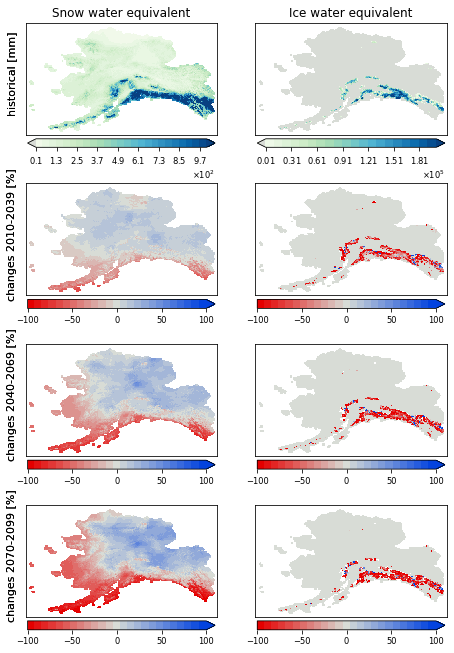

In [161]:
cm = {'history': cmap1,
      'change' : custom_div_cmap(numcolors=25, mincol='xkcd:red', midcol='xkcd:light grey', maxcol='xkcd:blue')}

sfmt = mpl.ticker.ScalarFormatter(useMathText=True)
sfmt.set_powerlimits((0, 0))

cbar_kwrgs = {'history':{"orientation":"horizontal", "shrink":0.980, "pad":0.03, 'format':sfmt},
              'change': {"orientation":"horizontal", "shrink":0.980, "pad":0.03}}

style_kwargs = {'history':{'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['history']},
                'change': {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['change']}
               }

kwargs = {'change':  {'vmin':-100, 'vmax':100,    'cmap':cm['change'],  'extend':'max', **style_kwargs['change']},
          'SWEmax':     {'levels':26, 'vmin':10,   'vmax':1010,   'cmap':cm['history'], 'extend':'both', **style_kwargs['history']},
          'IWE':     {'levels':21, 'vmin':1000, 'vmax':201000, 'cmap':cm['history'], 'extend':'both', **style_kwargs['history']}
         }

var_title = {'SWEmax':'Snow water equivalent', 'IWE':'Ice water equivalent'}

fig, axes = plt.subplots(nrows=4, ncols=2, sharex=True, sharey=True, figsize=(6.5,9))
plt.subplots_adjust(left=0.075, bottom=0.020, right=0.975, top=0.975, hspace=0.175)

for col, var in enumerate(['SWEmax','IWE']):
    histo_hydro_means.mean(dim='gcm')[var].plot.pcolormesh(ax=axes[0, col], **kwargs[var])
    
    early  = rcp85_hydro_30yr_diff['early'].mean(dim='gcm')[var].where(rcp85_hydro_30yr_diff['early'].mean(dim='gcm')[var]>-99)
    middle = rcp85_hydro_30yr_diff['middle'].mean(dim='gcm')[var].where(rcp85_hydro_30yr_diff['middle'].mean(dim='gcm')[var]>-99)
    late   = rcp85_hydro_30yr_diff['late'].mean(dim='gcm')[var].where(rcp85_hydro_30yr_diff['late'].mean(dim='gcm')[var]>-99)
    early.plot.pcolormesh(ax=axes[1, col], **kwargs['change'])
    middle.plot.pcolormesh(ax=axes[2, col], **kwargs['change'])
    late.plot.pcolormesh(ax=axes[3, col],   **kwargs['change'])
    
    add_ylabel(axes[0, 0], 'historical [mm]', fontsize=11)
    add_ylabel(axes[1, 0], 'changes 2010-2039 [%]', fontsize=11)
    add_ylabel(axes[2, 0], 'changes 2040-2069 [%]', fontsize=11)
    add_ylabel(axes[3, 0], 'changes 2070-2099 [%]', fontsize=11)
    axes[0, col].set_title(var_title[var], fontsize=12)
    
#plt.tight_layout()
if figSave:
    plt.savefig(f'NB-AK7_Fig2_winter_mean_snow_ice_pchange_rcp85.png', dpi=300)

------------
-  The same as above except for two future periods in 21st century (mid, and late)

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/u/home/mizuka

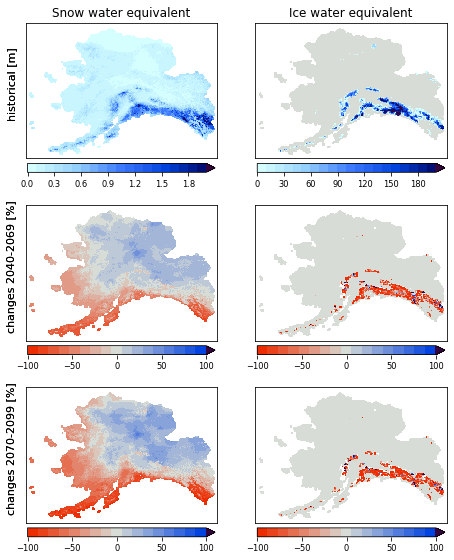

In [160]:
cm = {'history': cmap2,
      'change' : cmap3}

sfmt = mpl.ticker.ScalarFormatter(useMathText=False)
#sfmt.set_powerlimits((0, 0))

cbar_kwrgs = {'history':{"orientation":"horizontal", "shrink":0.980, "pad":0.03, 'format':sfmt},
              'change': {"orientation":"horizontal", "shrink":0.980, "pad":0.03}}

style_kwargs = {'history':{'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['history']},
                'change': {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs['change']}
               }

kwargs = {'change':  {'vmin':-100, 'vmax':100, 'cmap':cm['change'], 'extend':'max', **style_kwargs['change']},
          'SWEmax':  {'levels':21, 'vmin':0,  'vmax':2.0,   'cmap':cm['history'], 'extend':'max', **style_kwargs['history']},
          'IWE':     {'levels':21, 'vmin':0, 'vmax':200, 'cmap':cm['history'], 'extend':'max', **style_kwargs['history']}
         }

var_title = {'SWEmax':'Snow water equivalent', 'IWE':'Ice water equivalent'}

fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(6.5,7.75))
plt.subplots_adjust(left=0.075, bottom=0.020, right=0.975, top=0.970, hspace=0.100)

for col, var in enumerate(['SWEmax','IWE']):
    (histo_hydro_means/1000).mean(dim='gcm')[var].plot.pcolormesh(ax=axes[0, col], **kwargs[var])
    
    middle = rcp85_hydro_30yr_diff['middle'].mean(dim='gcm')[var].where(rcp85_hydro_30yr_diff['middle'].mean(dim='gcm')[var]>-99)
    late   = rcp85_hydro_30yr_diff['late'].mean(dim='gcm')[var].where(rcp85_hydro_30yr_diff['late'].mean(dim='gcm')[var]>-99)
    middle.plot.pcolormesh(ax=axes[1, col], **kwargs['change'])
    late.plot.pcolormesh(ax=axes[2, col],   **kwargs['change'])
    
    add_ylabel(axes[0, 0], 'historical [m]', fontsize=11)
    add_ylabel(axes[1, 0], 'changes 2040-2069 [%]', fontsize=11)
    add_ylabel(axes[2, 0], 'changes 2070-2099 [%]', fontsize=11)
    axes[0, col].set_title(var_title[var], fontsize=12)
    
if figSave:
    plt.savefig(f'NB-AK7_Fig3_winter_mean_snow_ice_pchange_mid_late_rcp85.png', dpi=300)

In [132]:
(histo_hydro_means/1000).mean(dim='gcm')[var][75:100,100:120].load()

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'IWE' (y: 25, x: 20)>
array([[ 5.08926436e-02, -1.00000011e-06, -1.00000011e-06,
         6.54075394e+01, -1.00000011e-06, -1.00000011e-06,
        -1.00000011e-06, -1.00000011e-06, -1.00000011e-06,
        -1.00000011e-06, -1.00000011e-06, -1.00000011e-06,
        -1.00000011e-06, -1.00000011e-06, -1.00000011e-06,
        -1.00000011e-06, -1.00000011e-06, -1.00000011e-06,
        -1.00000011e-06, -1.00000011e-06],
       [ 8.25796204e+01,  5.05395792e-03,  5.30054626e+01,
         7.44778290e+01, -1.00000011e-06, -1.00000011e-06,
        -1.00000011e-06,  1.02550475e-04, -1.00000011e-06,
        -1.00000011e-06, -1.00000011e-06, -1.00000011e-06,
        -1.00000011e-06, -1.00000011e-06, -1.00000011e-06,
        -1.00000011e-06, -1.00000011e-06, -1.00000011e-06,
        -1.00000011e-06, -1.00000011e-06],
       [ 1.19930824e+02,  1.13318871e+02,  1.18137901e+02,
         1.57986282e+02,  5.15468140e+01,  8.89570923e+01,
         7.14786301e+01,  9.30488663e+01, -1.00000011e-06,
        -1.00000011e-06, -1.00000011e-06, -1.00000011e-06,
        -1.00000011e-06, -1.00000011e-06, -1.00000011e-06,
        -1.00000011e-06, -1.00000011e-06, -1.00000011e-06,
...
        -1.00000011e-06, -1.00000011e-06, -1.00000011e-06,
        -1.00000011e-06, -1.00000011e-06, -1.00000011e-06,
        -1.00000011e-06, -1.00000011e-06, -1.00000011e-06,
        -1.00000011e-06, -1.00000011e-06, -1.00000011e-06,
        -1.00000011e-06, -1.00000011e-06, -1.00000011e-06,
        -1.00000011e-06, -1.00000011e-06],
       [-1.00000011e-06, -1.00000011e-06, -1.00000011e-06,
        -1.00000011e-06, -1.00000011e-06, -1.00000011e-06,
        -1.00000011e-06, -1.00000011e-06, -1.00000011e-06,
        -1.00000011e-06, -1.00000011e-06, -1.00000011e-06,
        -1.00000011e-06, -1.00000011e-06, -1.00000011e-06,
        -1.00000011e-06, -1.00000011e-06, -1.00000011e-06,
        -1.00000011e-06, -1.00000011e-06],
       [-1.00000011e-06, -1.00000011e-06, -1.00000011e-06,
        -1.00000011e-06, -1.00000011e-06, -1.00000011e-06,
        -1.00000011e-06, -1.00000011e-06, -1.00000011e-06,
        -1.00000011e-06, -1.00000011e-06, -1.00000011e-06,
        -1.00000011e-06, -1.00000011e-06, -1.00000011e-06,
        -1.00000011e-06, -1.00000011e-06, -1.00000011e-06,
        -1.00000011e-06, -1.00000011e-06]], dtype=float32)
Dimensions without coordinates: y, x

/glade/u/home/mizukami/anaconda3/envs/cmip5_oconus/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


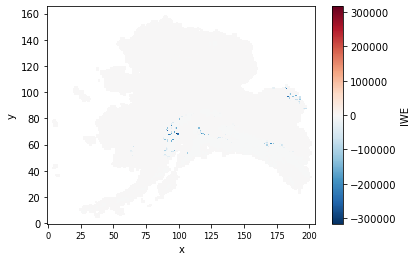

In [73]:
late1   = rcp85_hydro_30yr_diff['late'].mean(dim='gcm')[var]#.where(rcp85_hydro_30yr_diff['late'].mean(dim='gcm')[var]<=-99)
late1.plot.pcolormesh()

In [71]:
late1.load().values[75:125,140:148]

array([[  -100.     ,    -99.99924,    -99.99991, -16063.736  ,
                 nan,          nan,          nan,          nan],
       [         nan,          nan,  -7393.46   ,          nan,
                 nan,          nan,          nan,          nan],
       [         nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan],
       [         nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan],
       [         nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan],
       [         nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan],
       [         nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan],
       [         nan,          nan,          nan,          nan,
                 nan,          na

In [100]:
base = mpl.cm.seismic(np.arange(256))

In [135]:
lower

array([[0.9       , 0.9       , 0.9       , 1.        ],
       [0.9015873 , 0.9015873 , 0.89922191, 1.        ],
       [0.9031746 , 0.9031746 , 0.89844382, 1.        ],
       [0.9047619 , 0.9047619 , 0.89766573, 1.        ],
       [0.90634921, 0.90634921, 0.89688764, 1.        ],
       [0.90793651, 0.90793651, 0.89610955, 1.        ],
       [0.90952381, 0.90952381, 0.89533147, 1.        ],
       [0.91111111, 0.91111111, 0.89455338, 1.        ],
       [0.91269841, 0.91269841, 0.89377529, 1.        ],
       [0.91428571, 0.91428571, 0.8929972 , 1.        ],
       [0.91587302, 0.91587302, 0.89221911, 1.        ],
       [0.91746032, 0.91746032, 0.89144102, 1.        ],
       [0.91904762, 0.91904762, 0.89066293, 1.        ],
       [0.92063492, 0.92063492, 0.88988484, 1.        ],
       [0.92222222, 0.92222222, 0.88910675, 1.        ],
       [0.92380952, 0.92380952, 0.88832866, 1.        ],
       [0.92539683, 0.92539683, 0.88755058, 1.        ],
       [0.92698413, 0.92698413,